In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ephem 
from simons_array_python.calibration.planet import ephem_planet
from simons_array_python import sa_ephem as sa_ephem
import toast.qarray as qa
from simons_array_python import sa_sql
from toast.tod.sim_focalplane import cartesian_to_quat

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_iq.db attached.


In [3]:
#Convert Az/El to RA/dec using ephem
def azel_to_radecpa(mjd, az, el):
        observer = ephem_planet.pb2a_site()
        observer.pressure = 0
        ra, dec, pa = [], [], []
        for t, a, e in zip(mjd, az, el):
            observer.date = ephem_planet.mjd_to_djd(t)
            r, d = observer.radec_of(a, e)
            obj = ephem.FixedBody()
            obj._ra, obj._dec = r, d
            obj.compute(observer)
            ra.append(r)
            dec.append(np.pi/2-d)
            pa.append(-obj.parallactic_angle())
        return np.array(ra), np.array(dec), np.array(pa)

In [4]:
def plot_results(det=None, det_offset_x=None, det_offset_y=None):
    #Calculate det pntg with quats
    if det is not None:
        det_offset_x = sa_sql.db_impl.focalplane_db[det].det_offset_x
        det_offset_y = sa_sql.db_impl.focalplane_db[det].det_offset_y
    
    print(
        'Detector offsets x/y in degrees:',
        det_offset_x, 
        det_offset_y)
        
    det_offset_quat = cartesian_to_quat([[-det_offset_y, -det_offset_x, 0]])[0]
    det_pntg = qa.mult(boresight, det_offset_quat)
    theta, phi, pos = qa.to_angles(det_pntg)
    
    #Calculate det pntg with flat sky
    ra, dec, pa = azel_to_radecpa(times, az-(np.deg2rad(det_offset_x)/np.cos(el)) , el-np.deg2rad(det_offset_y)) 
    
    #Plot phi with RA, dec with theta, etc
    fig, axes = plt.subplots(3, figsize=(15,15))
    
    axes[0].plot(ra_boresight, label='boresight', alpha=0.75)    
    axes[0].plot(ra, label='flat', alpha=0.75)
    axes[0].plot(phi, label='quat', alpha=0.75)
    axes[0].legend()
    
    axes[1].plot(dec_boresight, label='boresight', alpha=0.75)    
    axes[1].plot(dec, label='flat', alpha=0.75)
    axes[1].plot(theta, label='quat', alpha=0.75)
    axes[1].legend()
    
    axes[2].plot(pa_boresight, label='boresight', alpha=0.75)    
    axes[2].plot(pa, label='flat', alpha=0.75)
    axes[2].plot(pos, label='quat', alpha=0.75)
    axes[2].legend()
    
    plt.show()
    
    print('Average errors in degrees',
        np.rad2deg(np.mean(phi-ra)),
        np.rad2deg(np.mean(theta-dec)),
        np.rad2deg(np.mean(pos-pa))
    )


In [5]:
#Load the boresight quaternions in celestial coordinates, along with the times and telescope Az/El timestreams
det_far = '13.11_267.90B'
det_close = '13.13_220.90T'

boresight = np.load('boresight_no_pressure.npy')

times = np.load('bolo_time.npy')
az = np.load('az.npy')
el = np.load('el.npy')
print(np.rad2deg(np.median(el)))

56.05161339722498


Average errors in degrees 0.007604124810368521 0.00832456025599157 0.23054277243298144


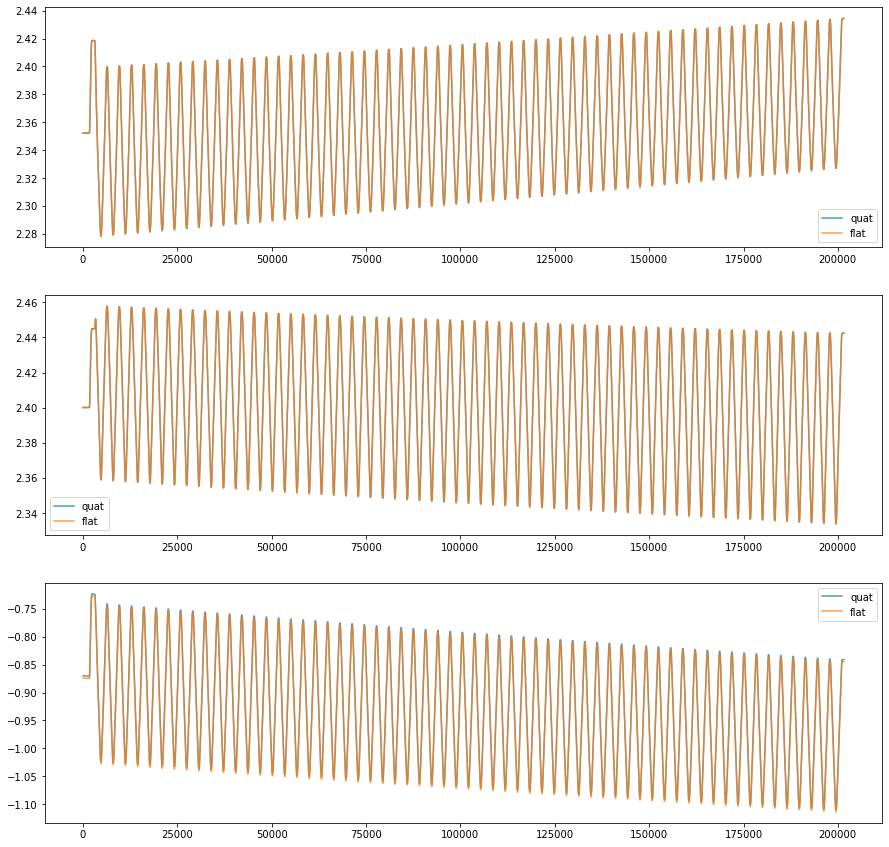

In [6]:
#First make sure the boresight_quats themselves agree with ephem
ra_boresight, dec_boresight, pa_boresight = azel_to_radecpa(times, az , el) 
theta_boresight, phi_boresight, pos_boresight = qa.to_angles(boresight)

fig, axes = plt.subplots(3, figsize=(15,15))

axes[0].plot(phi_boresight, label='quat', alpha=0.75)
axes[0].plot(ra_boresight, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_boresight, label='quat', alpha=0.75)
axes[1].plot(dec_boresight, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_boresight, label='quat', alpha=0.75)
axes[2].plot(pa_boresight, label='flat', alpha=0.75)
axes[2].legend()

print('Average errors in degrees',
    np.rad2deg(np.mean(phi_boresight-ra_boresight)),
    np.rad2deg(np.mean(theta_boresight-dec_boresight)),
    np.rad2deg(np.mean(pos_boresight-pa_boresight))
)
#Close enough?

Reading SQL table pb2a_focalplane...done.
Detector offsets x/y in degrees: -0.06831 -0.008328


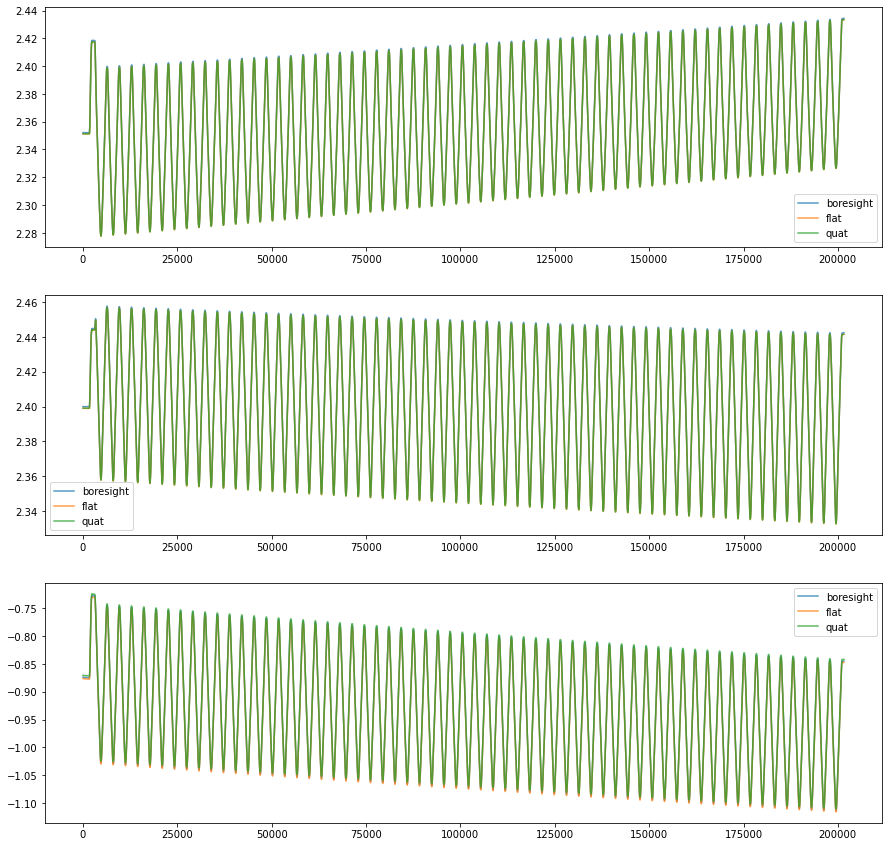

Average errors in degrees 0.007497573796408034 0.008352434553076557 0.3320772089760998


In [7]:
plot_results(det_close)

Detector offsets x/y in degrees: 2.004611 -1.56563


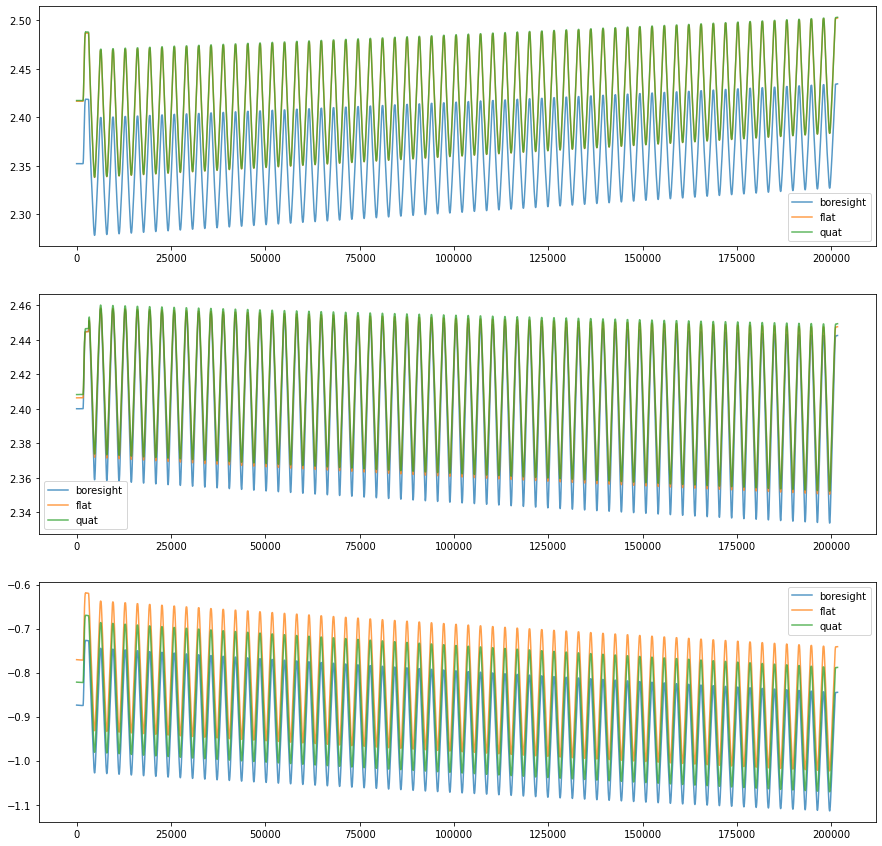

Average errors in degrees 0.030885422253244497 0.10346879393268475 -2.7597759654084784


In [8]:
plot_results(det_far)

Detector offsets x/y in degrees: 2 -2


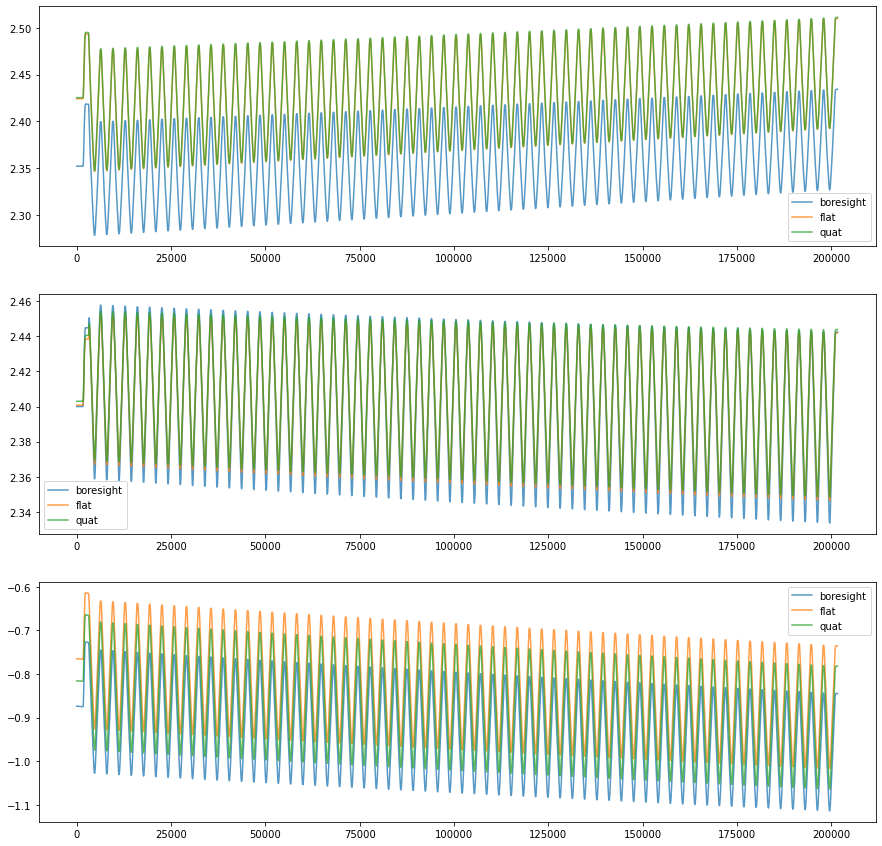

Average errors in degrees 0.054589353353030584 0.12004540002714117 -2.7420003777439357


In [9]:
#If you're unable to load the detector offsets from the database, can also enter then manually
plot_results(det_offset_x= 2, det_offset_y= -2)